# Testing LOSD
## Beschäftigte nach Beschäftigungsgrad

Diese Daten beinhalten Quantilwerte des steuerbaren Einkommens natürlicher Personen, die in der Stadt Zürich primär steuerpflichtig sind.

Diese Daten beinhalten aggreggierte Beschäftigtenzahlen in der Stadt Zürich und den nächsthöheren Ebenen. Die Daten für die Stadt Zürich werden nach diversen Merkmalen unterteilt (Sektor, Geschlecht, Beschäftigungsgrad). Ausserdem werden für die Stadt Zürich auch noch Vollzeitäquivalente ausgewiesen.

https://data.integ.stadt-zuerich.ch/dataset/wir400od4004

Datum: 24.05.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/xyz.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

Importiere die eigenen Funktionen, die unter ../0_scripts abegelegt sind:

In [3]:
import sys
sys.path.append('../0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

In [8]:
#speichere die variable global, damit ich sie später verwenden kann, wenn ich grafiken mit diesem namen speichere.
package_name = "wir400od4004"
#package_name = "bfs_wir_besch_bg_jahr_od4004"

In [9]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "wir400od4004"   #Das Datenformat muss nicht angegeben werden. Default .csv
    , datums_attr = ['ZEIT_LANG']
    )


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/WIR400OD4004/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/wir400od4004 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/WIR400OD4004 

data_source: web


In [10]:
data2betested.head(6)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEG_LANG,BEG_CODE,BES
0,2021-12-31,Z31122021,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,292600
1,2018-03-31,Z31032018,Stadt Zürich (ab 1934),R30000,Teilzeitbeschäftigte,BEG1200,187500
2,2015-09-30,Z30092015,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,274800
3,2005-09-30,Z30092005,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,247100
4,2021-12-31,Z31122021,Stadt Zürich (ab 1934),R30000,Teilzeitbeschäftigte,BEG1200,208900
5,2009-09-30,Z30092009,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,266800


In [11]:
data2betested.dtypes

ZEIT_LANG    datetime64[ns]
ZEIT_CODE            object
RAUM_LANG            object
RAUM_CODE            object
BEG_LANG             object
BEG_CODE             object
BES                 float64
dtype: object

Berechne weitere Attribute falls notwendig

In [12]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_LANG,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        Jahr = lambda x: x.ZEIT_LANG.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_CODE.str[-3:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested.head(2).T

,67,99
ZEIT_LANG,2024-03-31 00:00:00,2024-03-31 00:00:00
ZEIT_CODE,Z31032024,Z31032024
RAUM_LANG,Stadt Zürich (ab 1934),Stadt Zürich (ab 1934)
RAUM_CODE,R30000,R30000
BEG_LANG,Teilzeitbeschäftigte,Vollzeitbeschäftigte
BEG_CODE,BEG1200,BEG1100
BES,215900,304800
StichtagDatJahr,2024-03-31 00:00:00,2024-03-31 00:00:00
StichtagDatJahr_str,2024-03-31,2024-03-31
Jahr,2024,2024


Zeitbereich aus den Daten:

In [13]:
data_max_date = str(max(data2betested.ZEIT_LANG).year)
data_min_date = str(min(data2betested.ZEIT_LANG).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1985 und ein Maximumjahr von 2024


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [14]:
docname = package_name +date_today+".csv"
print(docname)

wir400od4004_2024-06-18.csv


In [15]:
data2betested.to_csv('./saved_data/'+docname, index=False)

### Einfache Datentests

In [16]:
data2betested.head(2).T

,67,99
ZEIT_LANG,2024-03-31 00:00:00,2024-03-31 00:00:00
ZEIT_CODE,Z31032024,Z31032024
RAUM_LANG,Stadt Zürich (ab 1934),Stadt Zürich (ab 1934)
RAUM_CODE,R30000,R30000
BEG_LANG,Teilzeitbeschäftigte,Vollzeitbeschäftigte
BEG_CODE,BEG1200,BEG1100
BES,215900,304800
StichtagDatJahr,2024-03-31 00:00:00,2024-03-31 00:00:00
StichtagDatJahr_str,2024-03-31,2024-03-31
Jahr,2024,2024


In [17]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 67 to 8
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_LANG            172 non-null    datetime64[ns]
 1   ZEIT_CODE            172 non-null    object        
 2   RAUM_LANG            172 non-null    object        
 3   RAUM_CODE            172 non-null    object        
 4   BEG_LANG             172 non-null    object        
 5   BEG_CODE             172 non-null    object        
 6   BES                  172 non-null    float64       
 7   StichtagDatJahr      172 non-null    datetime64[ns]
 8   StichtagDatJahr_str  172 non-null    object        
 9   Jahr                 172 non-null    int32         
 10  RAUM_my_sort         172 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(6)
memory usage: 84.7 KB


In [18]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 172 rows (observations) and 11 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei der Kennzahl?

In [19]:
data2betested[np.isnan(data2betested.BES)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEG_LANG,BEG_CODE,BES,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [20]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [21]:
data2betested.index.year.unique()

Index([1985, 1998, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype='int32', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [22]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [23]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BES,Jahr,RAUM_my_sort
count,172,172,172
mean,"220,067","2,013",0
std,"57,012",7,0
min,"71,512","1,985",0
25%,"170,075","2,008",0
50%,"224,910","2,013",0
75%,"272,925","2,018",0
max,"304,800","2,024",0


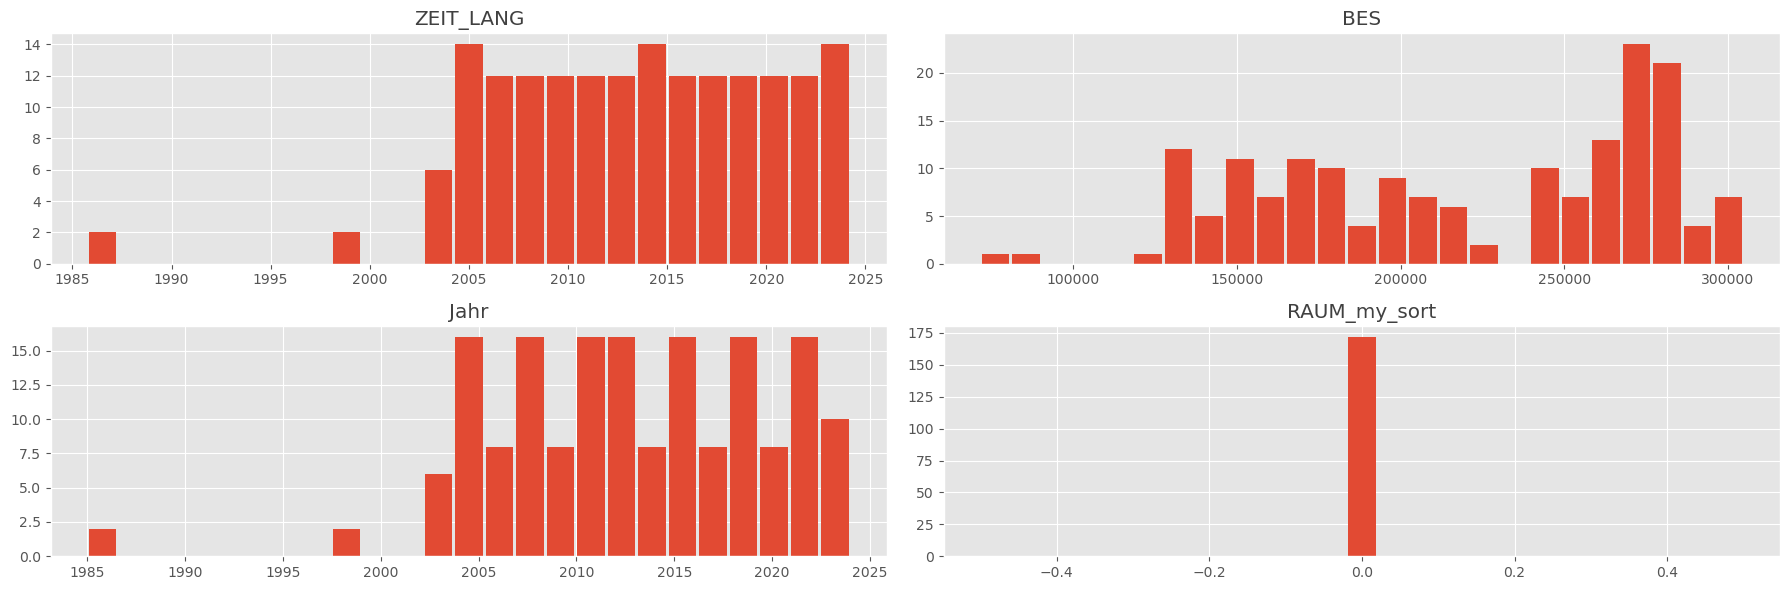

In [24]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [25]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEG_LANG,BEG_CODE,BES,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,


### Nullwerte und Missings?

In [26]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
BEG_LANG               0
BEG_CODE               0
BES                    0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

In [27]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
#import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [28]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr_str', 'ZEIT_LANG']) \
    .agg(sum_BES=('BES', 'sum')) \
    .sort_values('StichtagDatJahr_str', ascending=False) 
agg_jahr.reset_index()

,StichtagDatJahr_str,ZEIT_LANG,sum_BES
0,2024-03-31,2024-03-31,520700
1,2023-12-31,2023-12-31,525500
2,2023-09-30,2023-09-30,520000
3,2023-06-30,2023-06-30,522900
4,2023-03-31,2023-03-31,515100
...,...,...,...
81,2003-12-31,2003-12-31,375800
82,2003-09-30,2003-09-30,380800
83,2003-06-30,2003-06-30,379000
84,1998-09-30,1998-09-30,315287


In [29]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['RAUM_my_sort', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_BES=('BES', 'sum')) \
    .sort_values('RAUM_CODE', ascending=False) 
agg_Quarts.reset_index().head(50)

,RAUM_my_sort,RAUM_LANG,RAUM_CODE,sum_BES
0,0,Stadt Zürich (ab 1934),R30000,37851444


In [30]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEG_LANG', 'BEG_CODE', 'BES',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [31]:
agg_BG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['BEG_LANG', 'BEG_CODE',]) \
    .agg(sum_BES=('BES', 'sum')) \
    .sort_values('BEG_CODE', ascending=False) 
agg_BG.reset_index().head(5)

,BEG_LANG,BEG_CODE,sum_BES
0,Teilzeitbeschäftigte,BEG1200,14513279
1,Vollzeitbeschäftigte,BEG1100,23338165


### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [32]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEG_LANG,BEG_CODE,BES,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,
2024-03-31,2024-03-31,Z31032024,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,304800,2024-03-31,2024,0
2024-03-31,2024-03-31,Z31032024,Stadt Zürich (ab 1934),R30000,Teilzeitbeschäftigte,BEG1200,215900,2024-03-31,2024,0


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Beschäftigte

In [33]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEG_LANG', 'BEG_CODE', 'BES',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [34]:
myAgg1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr_str', 'ZEIT_LANG']) \
    .agg(sum_BES=('BES', 'sum')) \
    .sort_values('StichtagDatJahr_str', ascending=False) 
myAgg1.reset_index()

,StichtagDatJahr_str,ZEIT_LANG,sum_BES
0,2024-03-31,2024-03-31,520700
1,2023-12-31,2023-12-31,525500
2,2023-09-30,2023-09-30,520000
3,2023-06-30,2023-06-30,522900
4,2023-03-31,2023-03-31,515100
...,...,...,...
81,2003-12-31,2003-12-31,375800
82,2003-09-30,2003-09-30,380800
83,2003-06-30,2003-06-30,379000
84,1998-09-30,1998-09-30,315287


In [35]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index()
    , x = 'ZEIT_LANG:T'
    , y = 'sum_BES:Q'
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anzahl Beschäftigte'
    , warning_status  = "ignore"
    , category=''
    , category_beschriftung=''
    , myTitle = "Entwicklung Beschäftigten in der Stadt Zürich, seit "+str(data2betested.index.year.min())
)
grafik1

alt.LayerChart(...)

Speichere diese Grafik mit Zeitstempel:

In [36]:
grafic_name = package_name+"_alt1_besch_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)
#grafik1.save('grafiken_testing/'+grafic_name+'.html', embed_options={'renderer':'svg'})
grafik1.save('grafiken_testing/'+grafic_name)

grafiken_testing/wir400od4004_alt1_besch_total_2024-06-18.png


#### Entwicklung Beschäftigte nach Beschäftigungsgrad

In [37]:
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr_str', 'ZEIT_LANG','BEG_LANG', 'BEG_CODE',]) \
    .agg(sum_BES=('BES', 'sum')) \
    .sort_values('BEG_CODE', ascending=False) 
    
myAgg2.reset_index().head(5)

,StichtagDatJahr_str,ZEIT_LANG,BEG_LANG,BEG_CODE,sum_BES
0,1985-09-30,1985-09-30,Teilzeitbeschäftigte,BEG1200,71512
1,2017-06-30,2017-06-30,Teilzeitbeschäftigte,BEG1200,180600
2,2016-12-31,2016-12-31,Teilzeitbeschäftigte,BEG1200,181500
3,2016-09-30,2016-09-30,Teilzeitbeschäftigte,BEG1200,180600
4,2016-06-30,2016-06-30,Teilzeitbeschäftigte,BEG1200,182300


In [38]:
grafik2 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg2.reset_index()
    , x = 'ZEIT_LANG:T'
    , y = 'sum_BES:Q'
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anzahl Beschäftigte'
    , warning_status  = "ignore"
    , category='BEG_LANG:N'
    , category_beschriftung='BG:'
    , myTitle = "Entwicklung Beschäftigten nach Beschäftigungsgrad seit, "+str(data2betested.index.year.min())
)
grafik2

alt.LayerChart(...)

In [39]:
grafic_name = package_name+"_alt2_bg_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik2.save('grafiken_testing/'+grafic_name)

grafiken_testing/wir400od4004_alt2_bg_zeit_2024-06-18.png


#### Barcharts mit Seaborn

In [40]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

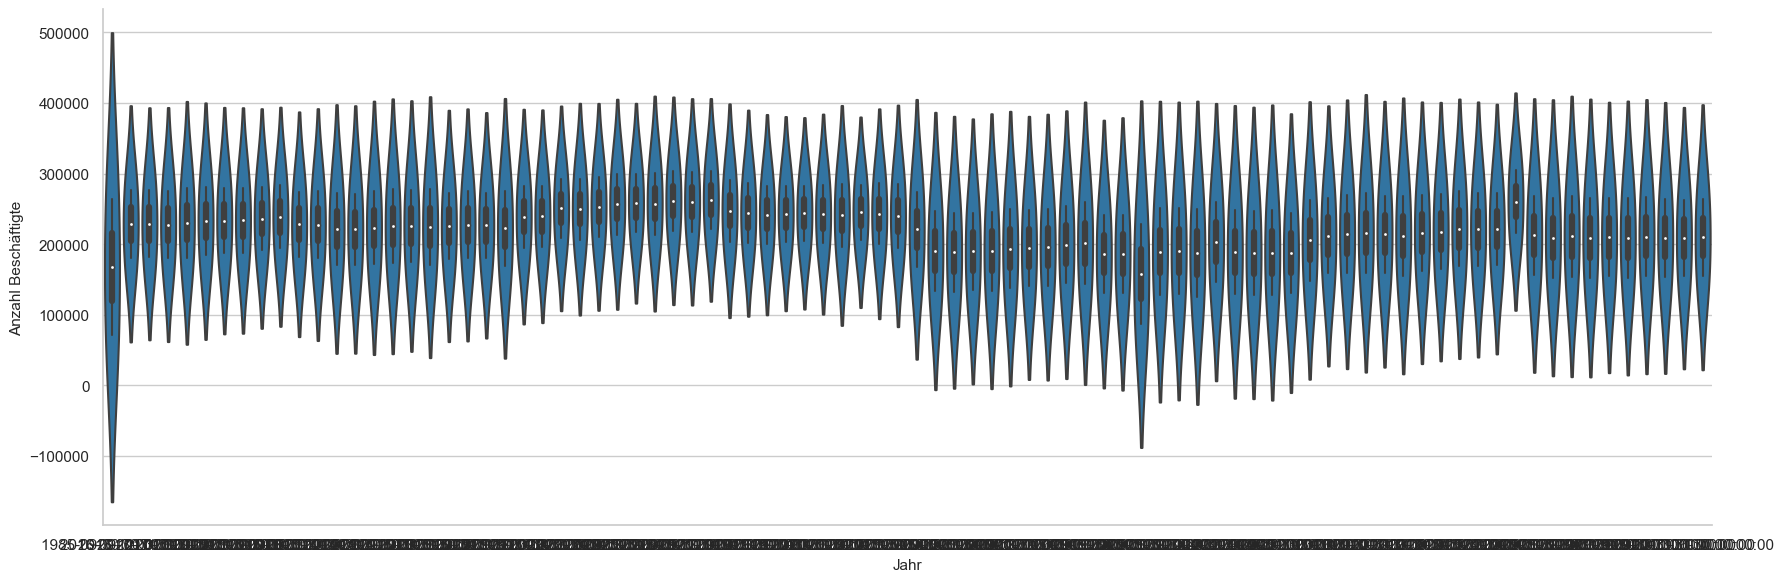

In [41]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="ZEIT_LANG"
            , y="BES"
            , hue="RAUM_LANG"
            , kind="violin" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="tab20" #, color="green" 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
            , height=6
            , aspect=3
            , edgecolor= None
            , order=None , legend_out=True, legend=False
            ,data=data2betested.loc[data_min_date:data_max_date]\
                     .reset_index().sort_values('RAUM_LANG', ascending = True)
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anzahl Beschäftigte', fontsize=11)

myHist


In [42]:
grafic_name = package_name+"_violin_bg_zeit"+date_today+".png"

print('grafiken_testing/'+grafic_name)


myHist.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/wir400od4004_violin_bg_zeit_2024-06-18.png


#### Faced Grids

In [43]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEG_LANG', 'BEG_CODE', 'BES',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [44]:
myFG =data2betested[['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEG_LANG', 'BEG_CODE', 'BES', 'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort']]\
                     .query('BES>10').loc[data_min_date:data_max_date]\
                     .reset_index().sort_values('RAUM_my_sort', ascending = True)

myFG.head(2)

,StichtagDatJahr,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEG_LANG,BEG_CODE,BES,StichtagDatJahr_str,Jahr,RAUM_my_sort
0,1985-09-30,1985-09-30,Z30091985,Stadt Zürich (ab 1934),R30000,Teilzeitbeschäftigte,BEG1200,71512,1985-09-30,1985,0
110,2016-09-30,2016-09-30,Z30092016,Stadt Zürich (ab 1934),R30000,Vollzeitbeschäftigte,BEG1100,277200,2016-09-30,2016,0


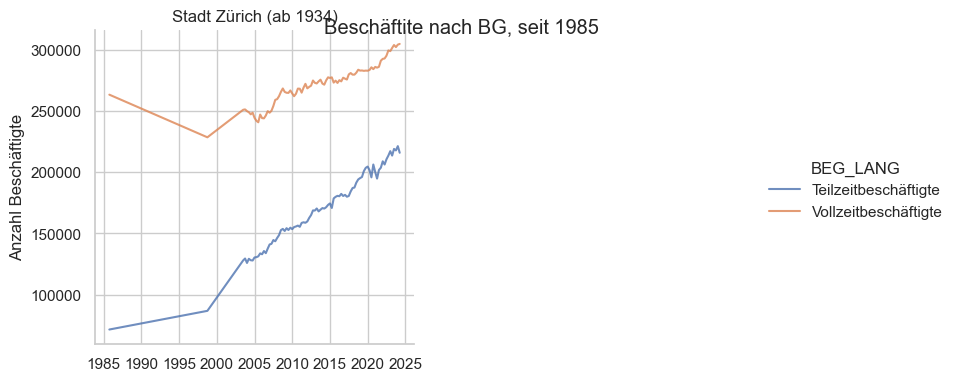

In [45]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG.reset_index()
    , col = "RAUM_LANG"
    , hue = "BEG_LANG"
    , col_wrap = 2
    , height = 6
    , grafiktyp = sns.lineplot
    , x = "StichtagDatJahr"
    , y = "BES"
    , ylabel= "Anzahl Beschäftigte"
    , myTitle="Beschäftite nach BG, seit "+str(data2betested.index.year.min())
    )

In [46]:
grafic_name = package_name+"_fg_besch_bg_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid1.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/wir400od4004_fg_besch_bg__2024-06-18.png


#### Treemaps

In [47]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEG_LANG', 'BEG_CODE', 'BES',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [48]:
myTM = data2betested.loc[data_min_date:data_max_date]\
    .groupby([ 'Jahr','BEG_LANG', 'BEG_CODE',]) \
    .agg(med_BES=('BES', 'median')) \
    .sort_values('BEG_CODE', ascending=False) 
    
myTM.reset_index().head(5)

,Jahr,BEG_LANG,BEG_CODE,med_BES
0,1985,Teilzeitbeschäftigte,BEG1200,71512
1,2009,Teilzeitbeschäftigte,BEG1200,153900
2,2024,Teilzeitbeschäftigte,BEG1200,215900
3,2023,Teilzeitbeschäftigte,BEG1200,218400
4,2022,Teilzeitbeschäftigte,BEG1200,212100


In [49]:
treeMap1 = mypy_dv.plot_px_treemap(
    data=myTM.reset_index()
    ,levels=["BEG_LANG", "Jahr" ]
    ,values="med_BES"
    ,color="BEG_LANG"
    ,myHeaderTitle="Beschäftigte nach Beschäftigungsgrad, seit "+data_min_date
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    #,margin_val_bottom=25
)
treeMap1


path: [<plotly.express._special_inputs.Constant object at 0x000002126D1123D0>, 'BEG_LANG', 'Jahr']
Typ von path: <class 'list'>


In [50]:
grafic_name = package_name+"_tm_besch_bg_jahr_"+date_today+".png"
print(grafic_name)

treeMap1.write_image('grafiken_testing/'+grafic_name)

wir400od4004_tm_besch_bg_jahr__2024-06-18.png


AttributeError: 'NoneType' object has no attribute 'write_image'

In [ ]:
treeMap2 = mypy_dv.plot_px_treemap(
    data=myTM.reset_index()
    ,levels=["Jahr", "BEG_LANG"]
    ,values="med_BES"
    ,color="BEG_LANG"
    ,myHeaderTitle="Beschäftigte nach Beschäftigungsgrad, seit "+data_min_date
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    #,margin_val_bottom=25
)

treeMap2 

path: [<plotly.express._special_inputs.Constant object at 0x0000028270F8F790>, 'Jahr', 'BEG_LANG']
Typ von path: <class 'list'>


In [ ]:
grafic_name = package_name+"_tm_jahr_besch_bg"+date_today+".png"
print(grafic_name)

treeMap2.write_image('grafiken_testing/'+grafic_name)

wir400od4004_tm_jahr_besch_bg_2024-05-28.png


AttributeError: 'NoneType' object has no attribute 'write_image'

## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=875&Source=https%3A%2F%2Fkollaboration%2Eintranet%2Estzh%2Ech%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs%2FOGD%2520Metadaten%2Easpx%23InplviewHasheb69a2c0%2Ded94%2D4ef2%2D91a5%2D3b19f038e442%3DFilterField1%253DMetadaten%25255Fx002d%25255FPublikations%25255Fx00%2DFilterValue1%253DINT&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)